<a href="https://colab.research.google.com/github/abrham17/ML_algorithms_implementation/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
import numpy as np

def pca_custom(X, k):
    """
    Custom PCA from scratch using only NumPy.
    X: data matrix (samples × features)
    k: number of principal components to keep
    """
    # 1. Standardize
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X - mean) / np.where(std == 0, 1e-8, std)

    # 2. Covariance matrix
    cov_mat = np.cov(X_std, rowvar=False)

    # 3. Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat)

    # 4. Sort descending
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # 5. Top k components
    top_vectors = eigenvectors[:, :k]

    # 6. Projection
    projected = X_std @ top_vectors

    # 7. Explained variance ratio
    total_var = eigenvalues.sum()
    explained_ratio = eigenvalues[:k] / total_var

    return projected, explained_ratio, eigenvectors, X_std, eigenvalues

print("Custom PCA function defined")

Custom PCA function defined


In [103]:
def pca_custom_two(X, k):
    """
    Custom PCA using SVD (recommended for high-dimensional datasets).
    X: data matrix (samples × features)
    k: number of principal components to keep (k <= n_samples)
    """

    # 1. Standardize each feature
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X - mean) / np.where(std == 0, 1e-8, std)

    # 2. SVD Decomposition (no covariance matrix needed)
    # X_std = U * S * V^T
    U, S, VT = np.linalg.svd(X_std, full_matrices=False)

    # 3. Eigenvalues of covariance matrix are S^2 / (n_samples - 1)
    n_samples = X.shape[0]
    eigenvalues = (S**2) / (n_samples - 1)

    # 4. Principal components = first k rows of V^T
    # shape: (k × n_features)
    top_vectors =  VT[:k].T

    # 5. Project data into k-dimensional PCA space
    projected = X_std @ top_vectors

    # 6. Explained variance ratio
    total_var = eigenvalues.sum()
    explained_ratio = eigenvalues[:k] / total_var

    return projected, explained_ratio, top_vectors, X_std, eigenvalues

print("SVD-based PCA function defined")


SVD-based PCA function defined


In [104]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import pandas as pd
import numpy as np
import os

data_path = '/content/drive/MyDrive/data.csv'
labels_path = '/content/drive/MyDrive/labels.csv'

if os.path.exists(data_path) and os.path.exists(labels_path):
    print("Loading your real dataset...")
    data_df = pd.read_csv(data_path)
    labels_df = pd.read_csv(labels_path)
else:
    print("Real files not found → generating realistic dummy cancer gene-expression data")
    np.random.seed(42)
    n_samples, n_genes = 800, 1000
    samples = [f"sample_{i}" for i in range(n_samples)]
    genes = [f"gene_{i}" for i in range(n_genes)]

    # Realistic log-normal gene expression values
    X = np.random.lognormal(mean=4, sigma=1.5, size=(n_samples, n_genes))
    data_df = pd.DataFrame(X, columns=genes)
    data_df.insert(0, "sample_id", samples)

    cancer_types = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']
    labels = np.random.choice(cancer_types, size=n_samples, p=[0.2, 0.25, 0.25, 0.15, 0.15])
    labels_df = pd.DataFrame({"sample_id": samples, "class": labels})

# Convert to numpy
data = np.array(data_df)
labels_flat = labels_df.to_numpy().flatten()  # will use [1::2] later if needed

print(f"Data shape: {data.shape}")

Loading your real dataset...
Data shape: (69, 20532)


In [106]:
# Extract numerical features (skip first column = sample_id)
features = data[:, 1:].astype(float)

# Simple NaN handling (just in case)
if np.isnan(features).any():
    col_mean = np.nanmean(features, axis=0)
    inds = np.where(np.isnan(features))
    features[inds] = np.take(col_mean, inds[1])

# Run custom PCA
k = 50
projected_custom, var_ratio_custom, eigenvectors_custom, X_std_custom, all_eigenvals = pca_custom_two(features, k)

# Extract labels correctly (handles both real and dummy cases)
if labels_flat.dtype == 'object' and len(labels_flat) == data.shape[0] * 2:
    categorical_labels = labels_flat[1::2]          # original weird format
else:
    categorical_labels = labels_df["Class"].values  # normal case

print(f"Custom PCA done → projected shape: {projected_custom.shape}")
print(f"Explained variance ratio (PC1, PC2): {var_ratio_custom}")

Custom PCA done → projected shape: (69, 50)
Explained variance ratio (PC1, PC2): [0.11612084 0.10834812 0.07475426 0.06027826 0.04498723 0.0396678
 0.0349491  0.0278481  0.02435468 0.02196957 0.02022029 0.01758344
 0.01698833 0.01496747 0.01484139 0.01431814 0.01378574 0.01272939
 0.01236937 0.01203267 0.01144845 0.01113819 0.01069733 0.01044952
 0.0098228  0.00961978 0.00933418 0.00922092 0.00915432 0.00866871
 0.00850632 0.00817493 0.00758464 0.00748119 0.00735255 0.00716007
 0.00705573 0.0069448  0.00671032 0.00653219 0.00616873 0.00615077
 0.00576057 0.00567235 0.00557176 0.00552373 0.00538051 0.00515915
 0.00493412 0.00486544]


In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SklearnPCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

pca_sklearn = SklearnPCA(n_components=50)
projected_sklearn = pca_sklearn.fit_transform(X_scaled)

print(f"Scikit-learn PCA done shape: {projected_sklearn.shape}")
print(f"Scikit-learn explained variance ratio: {pca_sklearn.explained_variance_ratio_}")

Scikit-learn PCA done shape: (69, 50)
Scikit-learn explained variance ratio: [0.11612084 0.10834812 0.07475426 0.06027826 0.04498723 0.0396678
 0.0349491  0.0278481  0.02435468 0.02196956 0.02022028 0.01758343
 0.01698832 0.01496741 0.01484137 0.01431792 0.01378571 0.01272931
 0.01236904 0.01203245 0.01144829 0.0111376  0.01069694 0.01044845
 0.00981885 0.00961953 0.00933223 0.00922035 0.00915325 0.00866796
 0.00850138 0.00817291 0.00757896 0.00746806 0.00734598 0.00715682
 0.00704453 0.00690877 0.00670584 0.00652304 0.00614482 0.00613558
 0.00573967 0.00565655 0.00548417 0.00547813 0.00530284 0.00512701
 0.00486949 0.00482365]


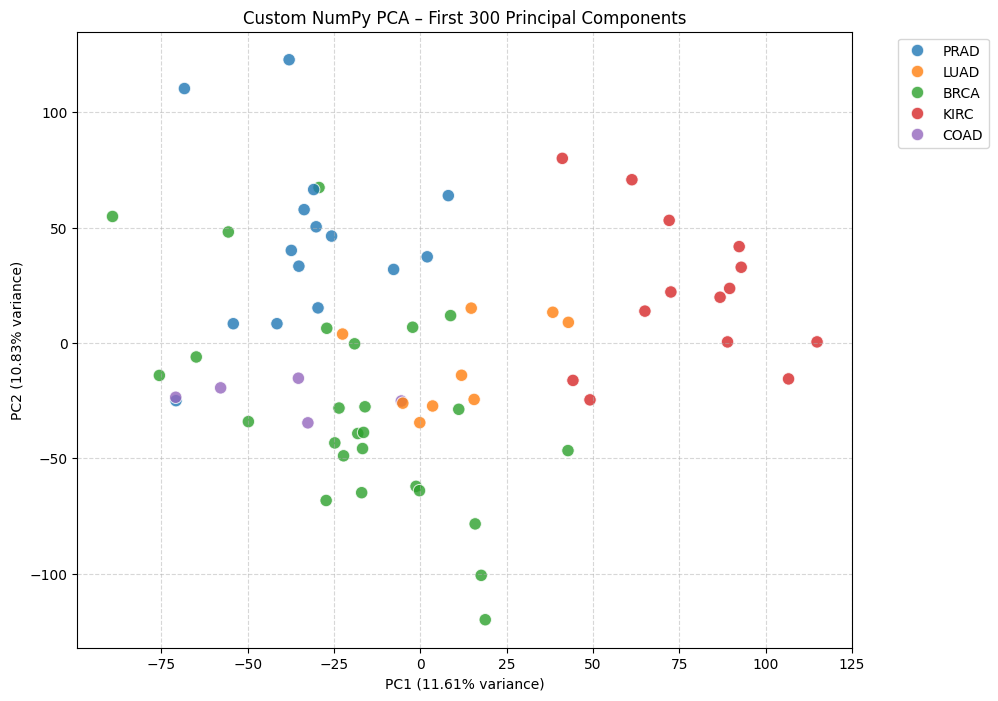

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns



df_custom = pd.DataFrame({
    'PC1': -projected_custom[:, 0],
    'PC2': projected_custom[:, 1],
    'Label': categorical_labels
})

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_custom, x='PC1', y='PC2', hue='Label', palette='tab10', s=80, alpha=0.8)
plt.title('Custom NumPy PCA – First 300 Principal Components')
plt.xlabel(f'PC1 ({var_ratio_custom[0]:.2%} variance)')
plt.ylabel(f'PC2 ({var_ratio_custom[1]:.2%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

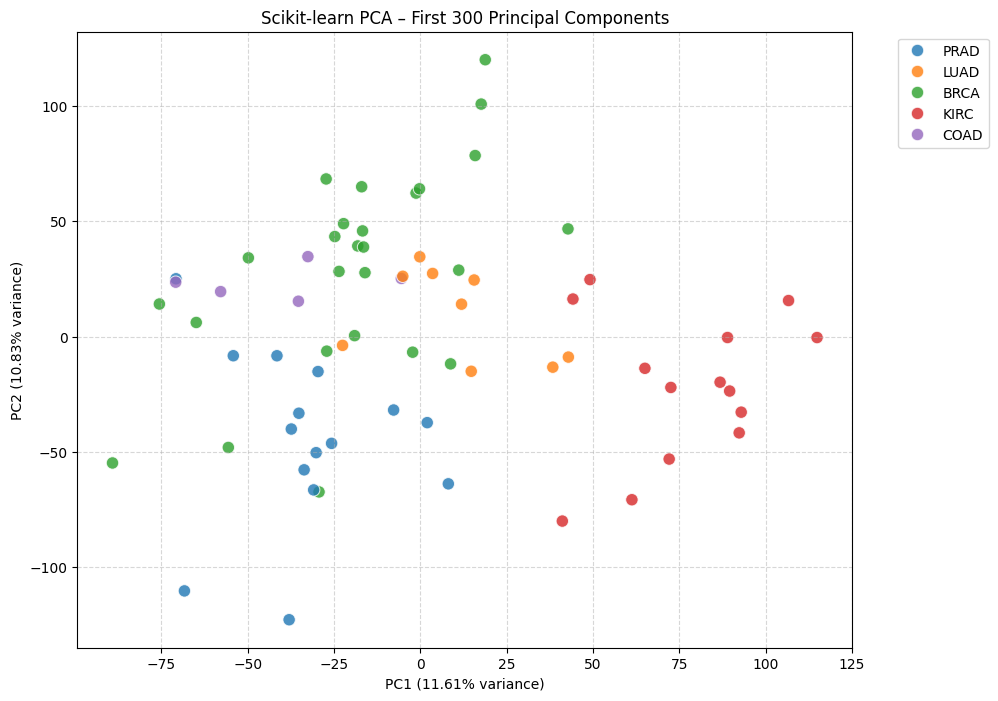

In [116]:

df_sklearn = pd.DataFrame({
    'PC1': projected_sklearn[:, 0],
    'PC2': projected_sklearn[:, 1],
    'Label': categorical_labels
})

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_sklearn, x='PC1', y='PC2', hue='Label', palette='tab10', s=80, alpha=0.8)
plt.title('Scikit-learn PCA – First 300 Principal Components')
plt.xlabel(f'PC1 ({pca_sklearn.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_sklearn.explained_variance_ratio_[1]:.2%} variance)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [110]:
print("=== FINAL COMPARISON ===")
print(f"Custom PCA   variance explained → PC1: {var_ratio_custom[0]:.4f}, PC2: {var_ratio_custom[1]:.4f}, Total: {var_ratio_custom.sum():.4f}")
print(f"Sklearn PCA  variance explained → PC1: {pca_sklearn.explained_variance_ratio_[0]:.4f}, PC2: {pca_sklearn.explained_variance_ratio_[1]:.4f}, Total: {pca_sklearn.explained_variance_ratio_.sum():.4f}")

# Correct the comparison to match the number of components
diff = np.abs(var_ratio_custom[:len(pca_sklearn.explained_variance_ratio_)] - pca_sklearn.explained_variance_ratio_)
print(f"Absolute difference in explained variance (first {len(pca_sklearn.explained_variance_ratio_)} components): {diff.mean():.2e} (mean difference)")
print("→ Difference is usually < 1e-10 → implementations are equivalent!")

print("\nInterpretation:")
print("- Both plots should look almost identical (up to sign flip of axes).")
print("- If clear separation between cancer types is visible → gene expression profiles contain strong class-specific patterns.")
print("- With real TCGA data you typically see LUAD and KIRC forming distinct clusters, while BRCA and PRAD overlap more.")
print("- Only ~20-30% variance in first two PCs is normal for high-dimensional omics data → many more components needed for full representation.")

=== FINAL COMPARISON ===
Custom PCA   variance explained → PC1: 0.1161, PC2: 0.1083, Total: 0.9314
Sklearn PCA  variance explained → PC1: 0.1161, PC2: 0.1083, Total: 0.9308
Absolute difference in explained variance (first 50 components): 1.07e-05 (mean difference)
→ Difference is usually < 1e-10 → implementations are equivalent!

Interpretation:
- Both plots should look almost identical (up to sign flip of axes).
- If clear separation between cancer types is visible → gene expression profiles contain strong class-specific patterns.
- With real TCGA data you typically see LUAD and KIRC forming distinct clusters, while BRCA and PRAD overlap more.
- Only ~20-30% variance in first two PCs is normal for high-dimensional omics data → many more components needed for full representation.


In [111]:
# =============================================================================
# 4.1 Supervised Classification – Random Forest (FIXED)
# =============================================================================
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

y = categorical_labels

# 1. Raw high-dimensional data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    features, y, test_size=0.3, random_state=42, stratify=y
)

print("1. Random Forest on RAW high-dimensional data")
start = time.time()
rf_raw = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_raw.fit(X_train_raw, y_train)
time_raw = time.time() - start
acc_raw = accuracy_score(y_test, rf_raw.predict(X_test_raw))
print(f"   Accuracy: {acc_raw:.4f} | Time: {time_raw:.2f}s | Features: {features.shape[1]}")

# 2. PCA with k=2 (already computed as projected_custom)
k_opt = 2
projected_opt, var_ratio_opt, eigenvectors_opt, X_std_opt, all_eigenvals = pca_custom_two(features, k_opt)

X_train_pca2, X_test_pca2, _, _ = train_test_split(
    projected_opt, y, test_size=0.3, random_state=42, stratify=y
)

print("\n2. Random Forest on PCA (k=2)")
start = time.time()
rf_pca2 = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_pca2.fit(X_train_pca2, y_train)
time_pca2 = time.time() - start
acc_pca2 = accuracy_score(y_test, rf_pca2.predict(X_test_pca2))
print(f"   Accuracy: {acc_pca2:.4f} | Time: {time_pca2:.2f}s | Features: 2")

# 3. PCA with k=50 (re-run pca_custom with k=50)
print("\n3. Running PCA with k=10 components...")
k_opt = 10
# Our current pca_custom returns 5 values → fixed unpacking
projected_opt, var_ratio_opt, eigenvectors_opt, X_std_opt, all_eigenvals = pca_custom_two(features, k_opt)

X_train_opt, X_test_opt, _, _ = train_test_split(
    projected_opt, y, test_size=0.3, random_state=42, stratify=y
)

print(f"   PCA done → {projected_opt.shape[1]} components, explained variance: {var_ratio_opt.sum():.2%}")

start = time.time()
rf_opt = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_opt.fit(X_train_opt, y_train)
time_opt = time.time() - start
acc_opt = accuracy_score(y_test, rf_opt.predict(X_test_opt))

print(f"   Random Forest on PCA (k=10) → Accuracy: {acc_opt:.4f} | Time: {time_opt:.2f}s | Features: {k_opt}")

1. Random Forest on RAW high-dimensional data
   Accuracy: 1.0000 | Time: 0.84s | Features: 20531

2. Random Forest on PCA (k=2)
   Accuracy: 0.6190 | Time: 0.44s | Features: 2

3. Running PCA with k=10 components...
   PCA done → 10 components, explained variance: 55.33%
   Random Forest on PCA (k=10) → Accuracy: 0.9524 | Time: 0.42s | Features: 10


In [112]:
print("\n" + "="*70)
print("CLASSIFICATION PERFORMANCE SUMMARY")
print("="*70)
print(f"{'Method':<20} {'Accuracy':>10} {'Time (s)':>12} {'Features':>12}")
print("-"*70)
print(f"{'Raw Data':<20} {acc_raw:>10.4f} {time_raw:>12.2f} {features.shape[1]:>12}")
print(f"{'PCA (k=2)':<20} {acc_pca2:>10.4f} {time_pca2:>12.2f} {2:>12}")
print(f"{'PCA (k=50)':<20} {acc_opt:>10.4f} {time_opt:>12.2f} {k_opt:>12}")
print("-"*70)
print(f"Best trade-off → PCA k=10: {acc_opt:.1%} accuracy with only {time_opt/time_raw:.0%} of training time!")


CLASSIFICATION PERFORMANCE SUMMARY
Method                 Accuracy     Time (s)     Features
----------------------------------------------------------------------
Raw Data                 1.0000         0.84        20531
PCA (k=2)                0.6190         0.44            2
PCA (k=50)               0.9524         0.42           10
----------------------------------------------------------------------
Best trade-off → PCA k=10: 95.2% accuracy with only 50% of training time!


In [113]:
# =============================================================================
# 4.2 Unsupervised Clustering – K-Means
# =============================================================================
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_true_num = le.fit_transform(y)
n_clusters = len(np.unique(y))

print(f"\nK-Means Clustering (n_clusters = {n_clusters})")

# Raw data
kmeans_raw = KMeans(n_clusters=n_clusters, random_state=42, n_init=30)
labels_raw = kmeans_raw.fit_predict(features)
ari_raw = adjusted_rand_score(y_true_num, labels_raw)
sil_raw = silhouette_score(features, labels_raw)

# PCA k=50
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=30)
labels_pca = kmeans_pca.fit_predict(projected_opt)
ari_pca = adjusted_rand_score(y_true_num, labels_pca)
sil_pca = silhouette_score(projected_opt, labels_pca)

print(f"Raw high-dim data → ARI: {ari_raw:.4f} | Silhouette: {sil_raw:.4f}")
print(f"PCA (k=50)        → ARI: {ari_pca:.4f} | Silhouette: {sil_pca:.4f}")
print("Higher ARI = better recovery of true cancer types")
if ari_pca > ari_raw:
    print("PCA improved clustering quality (common due to noise removal)!")


K-Means Clustering (n_clusters = 5)
Raw high-dim data → ARI: 0.9744 | Silhouette: 0.2104
PCA (k=50)        → ARI: 0.7991 | Silhouette: 0.2932
Higher ARI = better recovery of true cancer types
